# Advanced Classification Predict

Kaggle Challenge 2021 - Team_15_#MLC

---

### Predict Overview: 2021/2022 Climate Change Belief Analysis

Predict an individual’s belief in climate change based on historical tweet data.

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Introduction</a>

<a href=#two>2. Importing Packages</a>

<a href=#three>3. Loading Data</a>

<a href=#four>4. Data Cleaning and Preprocessing</a>

<a href=#five>5. Exploratory Data Analysis</a>

<a href=#six>6. Modeling</a>

<a href=#seven>7. Model Performance</a>

<a href=#eight>8. Conclusion</a>

<a href=#nine>9. Submission</a>

 <a id="one"></a>
## 1. Introduction

Create a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

### Data Description

Data The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were collected.

#### Start Comet Experiment

In [27]:
#Uncomment the below to create/start a new experiment on Comet

"""# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="0PXFIXjRITl64S9L8bH64cfYP",
    project_name="predict-advanced-classification-team-15",
    workspace="henriedwards",
)"""

'# import comet_ml at the top of your file\nfrom comet_ml import Experiment\n\n# Create an experiment with your api key\nexperiment = Experiment(\n    api_key="0PXFIXjRITl64S9L8bH64cfYP",\n    project_name="predict-advanced-classification-team-15",\n    workspace="henriedwards",\n)'

###### installations

In [28]:
!pip install wordcloud
!pip install textblob
!pip install scikit-plot
!pip install nltk
!pip install emoji --upgrade
!pip install comet_ml

 <a id="two"></a>
## 2. Importing Packages

In [29]:
# Ignore warnings
import warnings
warnings.simplefilter(action='ignore')

# Install Prerequisites
import sys
import nltk

# Exploratory Data Analysis
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Data Preprocessing
import string
import emoji
from bs4 import BeautifulSoup
from collections import Counter
from nltk.corpus import wordnet
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_list = stopwords.words('english')
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
from sklearn.utils import resample
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import TreebankWordTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from autocorrect import Speller

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC

# Performance Evaluation
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from scikitplot.metrics import plot_roc, plot_confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix




[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\happy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\happy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ModuleNotFoundError: No module named 'autocorrect'

<a id="three"></a>
## 3. Loading the Data
<a class="anchor" id="1.1"></a>

In [ ]:
train_df = pd.read_csv('train.csv')  # For model training
test_df = pd.read_csv('test_with_no_labels.csv') # For kaggle submission

train_df_eda = pd.read_csv('train.csv') # For EDA Purposes
test_df_eda = pd.read_csv('test_with_no_labels.csv') # For EDA Purposes

train_df_hashtag = pd.read_csv('train.csv') # For Hashtag Analysis

<a id="four"></a>
## 4. Data Cleaning and Preprocessing
<a class="anchor" id="1.1"></a>
We will be using Natural Language Processing. Natural Language Processing (NLP) is a field of Artificial Intelligence (AI) that makes human language intelligible to machines. Capable of understanding, analyzing, and extracting meaning from text and speech.

In [ ]:
train_df.head(3) # Basic Exploration of the Data.

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562


In [ ]:
test_df.head(3) #Basic Exploration of the Data.

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985


We can clearly see noise present in the data. Text Cleaning is needed. 

In [ ]:
# Rows - 15819, Columns -3
train_df.shape

(15819, 3)

In [ ]:
# Look for null values and sum the total by each feature
train_df.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

### Text Cleaning - Noise Removal
One of the key steps in processing language data is to remove noise so that the machine can more easily detect the patterns in the data. Text data contains a lot of noise, this takes the form of special characters such as hashtags, punctuation and numbers. All of which are difficult for computers to understand if they are present in the data.

- Lowercase the text for better data cleaning.
- We are dealing with messages with emojis, we can use Demojize to change a emoji to a string that best represents the emoji.
- Replacing the hyperlink with standard url text appears to have a large positive impact on how the model performs.
- Tokenisation is the process by which a large quantity of text is divided into smaller parts called tokens. These tokens are very useful for finding patterns and are considered as a base step for stemming and lemmatization.
- Lemmatization is the process of converting a word to its base form, which can be useful by easily grouping all the words with the same meaning together, as Lemmatization focuses on the context of the word as well.

In [ ]:
def cleaning(text):

    """Function that takes in a message / string and returns a cleaned text in the form of a string. """   
    
    # Lower case Text    
    text = text.lower()
    # Change emoji to descriptive text
    text = emoji.demojize(text, delimiters=('', ''))    
    # Replace urls with 'url'
    text = re.sub(r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+', 'url', text)
    # Remove Puncuation
    text = ' '.join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
    # Removing non-alphabets
    text = re.sub('[^a-z]', ' ',text)
    # Tokenisation & Lemmatisation
    text = [lemmatizer.lemmatize(token) for token in text.split(' ')]
    text = [lemmatizer.lemmatize(token, 'n') for token in text]
    text = [lemmatizer.lemmatize(token, 'v') for token in text]    
    text = [lemmatizer.lemmatize(token, 'a') for token in text]
    text = [lemmatizer.lemmatize(token, 'r') for token in text]
    text = ' '.join(text)
    
    return text

#Apply data cleaning function to data
train_df['final_message'] = train_df['message'].map(cleaning)
test_df['final_message'] = test_df['message'].map(cleaning)

Note: We chose to keep stop words in the final model, as stop words removal decreased the performance of our final model.

In [ ]:
# We can see that the above funtion has been applied.
train_df.head(3)

,sentiment,message,tweetid,final_message
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesn t think carbon di...
1,1,It's not like we lack evidence of anthropogeni...,126103,it s not like we lack evidence of anthropogeni...
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt rawstory researcher say we have three year ...


<a id="five"></a>
## 5. Exploratory Data Analysis
<a class="anchor" id="1.1"></a>

- **WordClouds** - We will use wordclouds to highlight the most frequently used words in each sentiment.
- **Data Distribution** - Using data distribution we can see where the majority of data lies.
- **Sentiment Analysis** - We will analyse each sentiment and be able to pull relevant insights per sentiment. 
- **Polarity** - We can use this to see what emotions are expressed in a tweet.
- **Subjectivity** - We will be able to see how opinionated or factual the tweets are.
- **Hashtag Analysis** - The most common hashtags may provide meanful insights.
- **Word Frequency** - We can see what is the most frequently occuring words, and possibly use this insight in preprocessing.
- **Bigrams** - Some words might occur more often together as apart, we can possibly use co-occuring words as a single entity.

#### Sentiment Class Description:

- **(2) News:** the tweet links to factual news about climate change

- **(1) Pro:** the tweet supports the belief of man-made climate change

- **(0) Neutral:** the tweet neither supports nor refutes the belief of man-made climate change

- **(-1) Anti:** the tweet does not believe in man-made climate change

### WordClouds

WordClouds are used to visualize text data and display their frequency using size. The bigger the word, the more the word is used in the input text.

We create a function to clean the train_df_eda to a certain useful extent. 

In [ ]:
def wordcloud(text):

    """Function that takes in a message / string and returns a cleaned text in the form of a string. """   
    
    # Lower case Text    
    text = text.lower()
    # Remove urls
    text = re.sub(r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+', '', text)
    # Removing non-alphabets
    text = re.sub('[^a-z]', ' ',text)
    text = ' '.join(word for word in text.split() if word not in stopwords_list) #Remove Stopwords
    return text

#Apply data cleaning function to data
train_df_eda['final_message'] = train_df_eda['message'].map(wordcloud)

Plotting the WordCloud based on climate change sentiments.

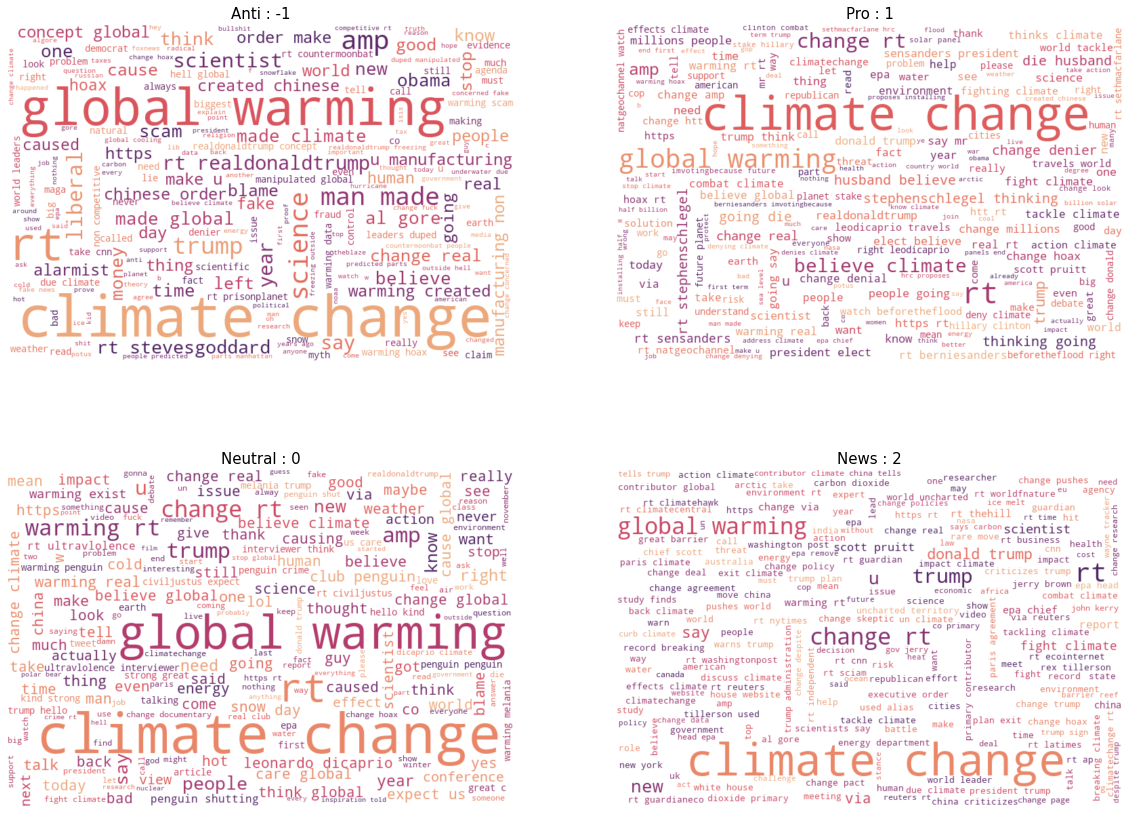

In [ ]:
# Extract the messages based on what sentiment it occurs in.
anti = ' '.join([text for text in train_df_eda['final_message'][train_df['sentiment']==-1]])
neutral = ' '.join([text for text in train_df_eda['final_message'][train_df['sentiment']==0]])
pro = ' '.join([text for text in train_df_eda['final_message'][train_df['sentiment']==1]])
news = ' '.join([text for text in train_df_eda['final_message'][train_df['sentiment']==2]])

# Create skeleton plots, 2 by 2
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

# Create wordcloud that represents Anti (-1) sentiment
anti_wc = WordCloud(width=750, height=500, background_color='white', colormap='flare').generate(anti)
axis[0, 0].imshow(anti_wc, interpolation="bilinear")
axis[0, 0].set_title('Anti : -1',fontsize=15)
axis[0, 0].axis("off") 

# Create wordcloud that represents Neutral (0) sentiment
neutral_wc = WordCloud(width=750, height=500, background_color='white', colormap='flare').generate(neutral)
axis[1, 0].imshow(neutral_wc, interpolation="bilinear")
axis[1, 0].set_title('Neutral : 0',fontsize=15)
axis[1, 0].axis("off") 

# Create wordcloud that represents Pro (1) sentiment
pro_wc = WordCloud(width=750, height=500, background_color='white', colormap='flare').generate(pro)
axis[0, 1].imshow(pro_wc, interpolation="bilinear")
axis[0, 1].set_title('Pro : 1',fontsize=15)
axis[0, 1].axis("off") 

# Create wordcloud that represents News (2) sentiment
news_wc = WordCloud(width=750, height=500, background_color='white', colormap='flare').generate(news)
axis[1, 1].imshow(news_wc, interpolation="bilinear")
axis[1, 1].set_title('News : 2',fontsize=15)
axis[1, 1].axis("off") 

plt.show()

Here, we can see that 'climate change' and 'global warming' are the most frequently occurring words for almost every sentiment.

Other insights per sentiment:

- **Anti (-1):** 'Man made', 'Science', 'Hoax', 'Trump'
- **Neutral (-0):** 'Trump', 'Weather', 'Think'
- **Pro (1):** 'beforetheflood', 'Fighting Climate'
- **News (2):** 'Scientist', 'Trump' (this sentiment is more balanced)

Oone can see that Anti (-1) has more retweets than Pro (1) (by looking at the size of 'rt')

### Data Distribution
Data Distribution shows us the proportion of tweets per sentiment.

In [ ]:
# Get the total count of each sentiment.
value_counts = train_df["sentiment"].value_counts()
value_counts.name = "Presence"

value_normd = train_df["sentiment"].value_counts(normalize=True)
for key, value in value_normd.items():
    value_normd[key] =  round(value*100,3)
value_normd.name = "Percentage"

display(pd.concat([value_counts, value_normd], axis=1))

,Presence,Percentage
1,8530,53.922
2,3640,23.010
0,2353,14.875
-1,1296,8.193


Above we can see the Visualizing of our sentiment training data. We will visualize these number for better understanding.

In [ ]:
# Replacing the numerical forms of sentiment with a string form, easier to read and understand. Change only for EDA

class_to_name = { # creating of dictionary for sentiment reference.
    -1: "Anti",
     0: "Neutral",
     1: "Pro",
     2: "News",
}

train_df_eda["sentiment"] = train_df_eda["sentiment"].apply(lambda num: class_to_name[num])
# Replace numerical sentiment with string sentiment as per above dictionary. 

train_df_eda.head(2) # display to see changes

,sentiment,message,tweetid,final_message
0,Pro,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief think carbon dioxide ma...
1,Pro,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming


Sentiment change applied above. (for instance, '-1' = "Anti)

#### Visualizing the Distribution of our Data

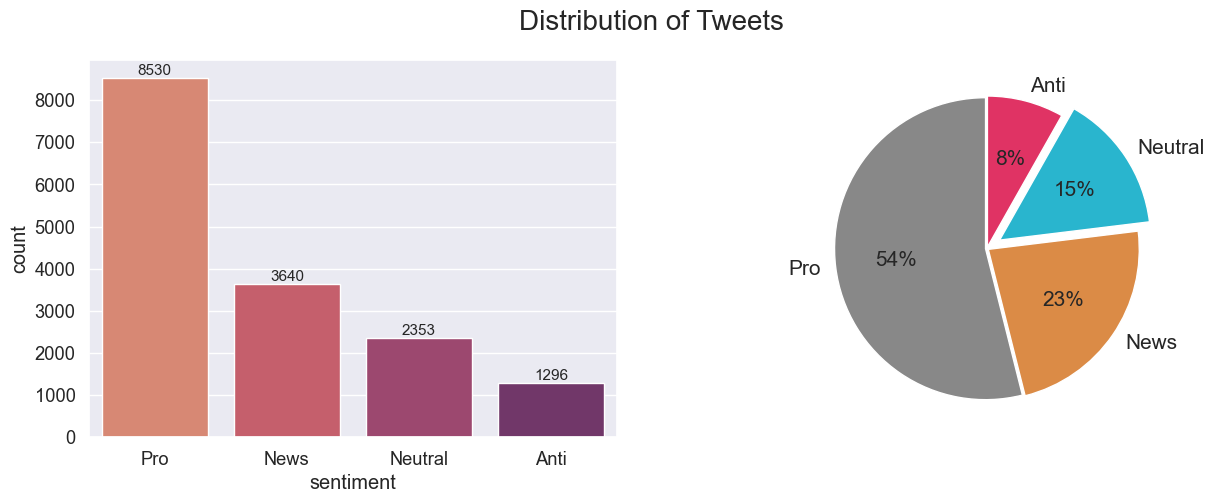

In [31]:
# Visualize the Distribution per sentiment.

fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=100) # multiple plots

#create countplot
ax = sns.countplot(train_df_eda["sentiment"], palette ='flare',ax=axes[0])
sns.set(font_scale=1.2)
labels = list(class_to_name.values())
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2., i.get_height(), '%d' % int(i.get_height()), fontsize=11, ha='center', va='bottom')


colors = ['#888888', '#db8b46', '#29b5ce', '#e03364'] 
explode = (0.01, 0.01, 0.1, 0.01) 

#plot pie plot
axes[1].pie(train_df_eda["sentiment"].value_counts(),
            labels=['Pro', 'News', 'Neutral', 'Anti'],
            colors=colors,
            autopct="%1.0f%%",
            startangle=90,
            explode=explode,
            textprops={'fontsize': 15})


fig.suptitle("Distribution of Tweets", fontsize=20)
plt.show()

We can note that the data is concentrated in the sentiment Pro(1), with over 50 % of the data present, which is 6 times the amount of the sentiment with the least percenrage of data Anti(-1).

### Sentiment Analysis
We apply sentiment analysis to see if we can pull any insights from how the data is present in each sentiment class.

In [ ]:
frequency = {}

by_sentiment = train_df.groupby("sentiment")
for sentiment, group in by_sentiment:
    cv = CountVectorizer(stop_words='english', 
                             min_df=2, 
                             max_df=0.6, 
                             ngram_range=(1,2))
    words = cv.fit_transform(group["final_message"])
    
    n_words = words.sum(axis=0)
    word_freq = [(word, n_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    
    freq = pd.DataFrame(word_freq, columns=["word", "freq"])
    
    frequency[sentiment] = freq.head(n=10)

to_view = pd.concat(frequency, axis=1).head(n=10)
display(to_view) # visualize top 10s

-1                    0                      1        \
             word freq            word  freq             word  freq   
0         climate  812         climate  1453              url  4195   
1          change  787          change  1430           global  1605   
2  climate change  754  climate change  1413             warm  1519   
3              rt  686              rt  1092      global warm  1449   
4          global  641          global  1040            trump  1125   
5            warm  626            warm  1027       change url  1050   
6     global warm  613     global warm  1011          believe  1030   
7             url  539             url   862            think   827   
8            make  154           trump   184            doesn   769   
9             man   97             say   141  believe climate   720   

             2        
          word  freq  
0           rt  2151  
1        trump  1069  
2   change url   848  
3      url url   769  
4       global   511  
5         warm   450  
6  global warm   431  
7          say   339  
8          epa   264  
9    scientist   217

#### Observation from our categories frequency table above :

(In a lemmatized tweet)

- the words "believe climate change", appear the most in tweets with a "Pro" sentiment, it could be that they are trying to communicate to others to believe in climate change

- interestingly the most frequent category of words in "Anti" sentiment is simarly "man climate change", however even this lemmatized phrase almost conveys a sentiment. it could be as responses to tweets by the "Pro" tweeters 

- In the "News", we observe that "trump " joins climate change in the buzz words group, as president as the time he would have had something to say and as a result his thoughts on it would become a topic. 

### Word Frequency
We can use word frequency to see the most common words in our feature column.

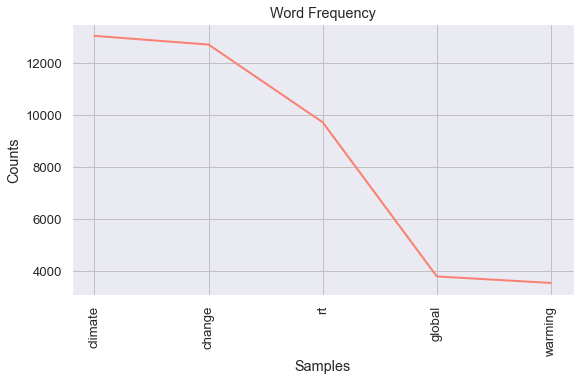

In [ ]:
# Most mentioned words.
# From lists of comments to a single list containing all words. 

all_words=[]        
for i in range(len(train_df)):
    x = train_df_eda['final_message'][i]
    a = x.split()
    all_words.append(a)

# Create sublist to have all data types in list not str.
flat_list = []
for sublist in all_words:
    for word in sublist:
        flat_list.append(word)

# Word frequency.
nlp_words = nltk.FreqDist(flat_list)
plt.figure(figsize=(9,5))
plot1 = nlp_words.plot(5, color='salmon', title='Word Frequency')  

    

The most commons words used are 'climate', 'change', 'retweet', 'global', 'warming'.

### Bigrams
A bigram or digram is a sequence of two adjacent elements from a string of tokens, which are typically letters, syllables, or words. A bigram is an n-gram for n=2. 

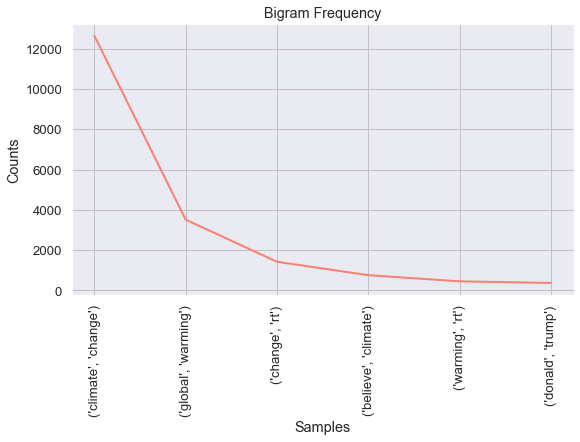

<AxesSubplot:title={'center':'Bigram Frequency'}, xlabel='Samples', ylabel='Counts'>

In [ ]:
# Most frequent pair of words that are next to each other in a comment.
bigrm = list(nltk.bigrams(flat_list))
words_2 = nltk.FreqDist(bigrm)
plt.figure(figsize=(9,5))
words_2.plot(6, color='salmon', title='Bigram Frequency')


We can note that the top bigrams are: 'climate change', 'global warming', 'change retweet', 'believe climate', 'warming retweet' and 'donald trump'

### Subjectivity
Subjectivity refers to a higher leaning of it being an opinion rather than factual information.

In [ ]:
"""Function takes in the dataframe and return the dataframe with polarity,
    Subjectivity_Category ,and Subjectivity columns.
"""
def sentiment_analysis(train_df):
    
    """ The following function takes in the dataframe and return  subjectivity of a dataframe."""
   
    def getSubjectivity(train_df):
        return TextBlob(train_df).sentiment.subjectivity
  
    """ The following function takes in the dataframe and generate polarity values of the dataframe."""
    def getPolarity(train_df):      
        return TextBlob(train_df).sentiment.polarity
  
    # Inserting two new columns ‘Subjectivity’ & ‘Polarity’ in the Dataframe
    train_df['Subjectivity'] =  train_df['message'].apply(getSubjectivity)
    train_df ['Polarity'] = train_df['message'].apply(getPolarity)
    
    """ The following function takes in a score of Polarity and categorise it weather Negative, 
        Positive or Neutral on Subjectivity_Category. 
    """
    def getAnalysis(score):
        if score < 0:
            return 'Negative'
        elif score == 0:
            return 'Neutral'
        else:
            return 'Positive'
    train_df ['Subjectivity_Category'] = train_df  ['Polarity'].apply(getAnalysis )
    return train_df.head() # Displaying the data frame to see the changes.

In [ ]:
sentiment_analysis(train_df)

,sentiment,message,tweetid,final_message,Subjectivity,Polarity,Subjectivity_Category
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesn t think carbon di...,0.166667,0.083333,Positive
1,1,It's not like we lack evidence of anthropogeni...,126103,it s not like we lack evidence of anthropogeni...,0.000000,0.000000,Neutral
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt rawstory researcher say we have three year ...,0.600000,-0.300000,Negative
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wire wa a pivotal year in th...,0.800000,0.500000,Positive
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt soynoviodetodas it s and a racist sexi...,0.000000,0.000000,Neutral


We can visualize the Polarity and Subjectivity to get a better understanding.

Text(0, 0.5, 'Subjectivity')

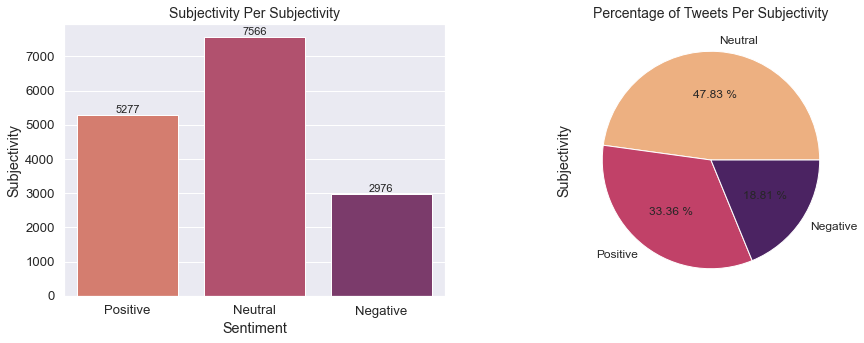

In [ ]:
# Visualize the Distribution per sentiment.
fig, axis = plt.subplots(ncols=2, figsize=(15, 5))

# create countplot
ax = sns.countplot(x='Subjectivity_Category', data=train_df, palette='flare', ax=axis[0])
axis[0].set_title('Subjectivity Per Subjectivity',fontsize=14)
axis[0].set_xlabel('Sentiment')
axis[0].set_ylabel('Subjectivity')
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2., i.get_height(), '%d' % int(i.get_height()), fontsize=11, ha='center', va='bottom')

# create pie plot    
train_df['Subjectivity_Category'].value_counts().plot.pie(autopct='%1.2f %%', colormap='flare', textprops={'fontsize': 12})
axis[1].set_title('Percentage of Tweets Per Subjectivity',fontsize=14)
axis[1].set_ylabel('Subjectivity')

### Polarity
Polarity  refers to a higher incidence of emotional, judgmental words.

(0.0, 1000.0)

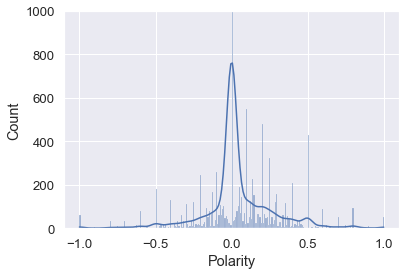

In [ ]:
# Here we are checking for the distribution of Polarity.
sns.histplot(data=train_df, x="Polarity", kde=True)
plt.ylim(0, 1000)

We measure the polarity in a range from -1 to 1. Noting that most of the data lies near 0, with some outlying data on both sides of 0. One can say the distribution is slightly leaning towards the more polarizing side.

### Hashtag Analysis
We can extract the Hashtag data from the raw data to find out what is the popular hashtags used by each sentiment.

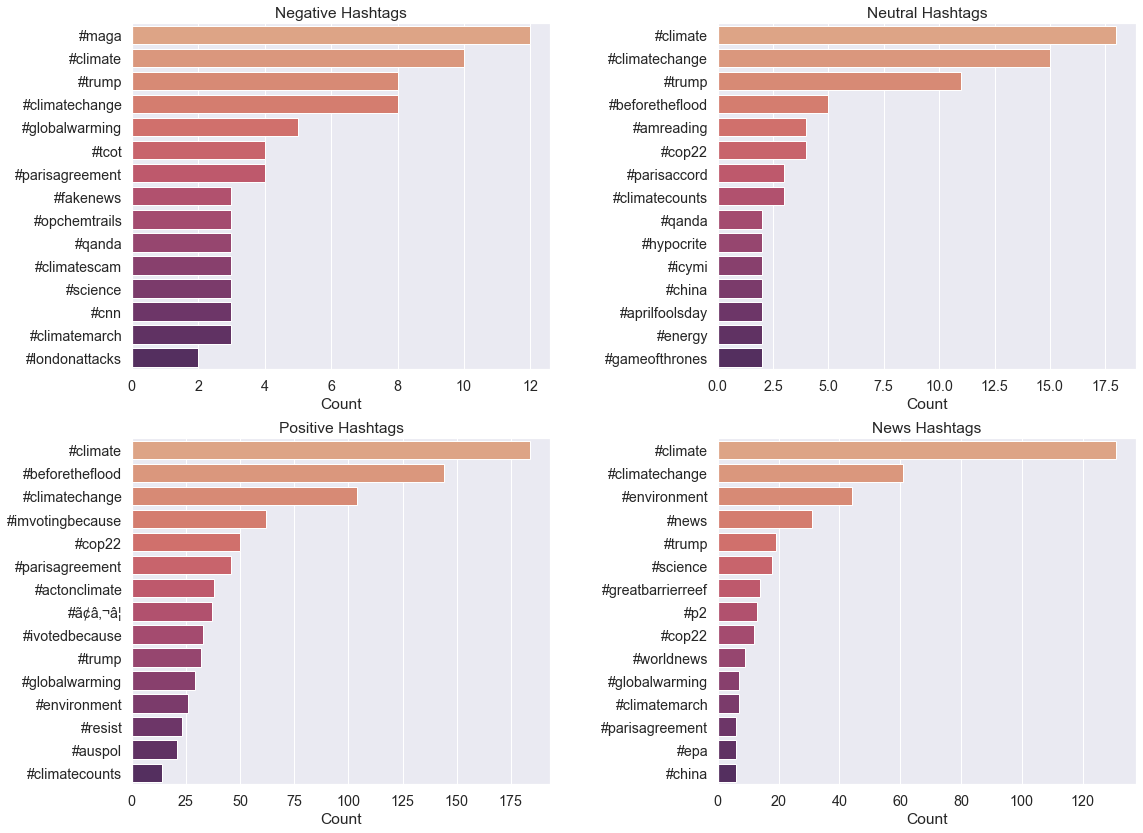

In [ ]:
def hashtag(text, symbol='#'): #function that takes in text, and extracts the necessary data based on the symbol
    
    """ Function takes in a dataframe column and specified symbol, returns extracted symbol and text"""
    
    return [tag.lower() for tag in text.split() if tag.startswith(symbol)]

train_df_hashtag['hashtags'] = train_df_hashtag['message'].apply(hashtag) # apply the function


"""
The following code extracts the hashtags based on each sentiment, and gets the sum of each hashtag

"""

negative_hashtag = train_df_hashtag['hashtags'][train_df_hashtag['sentiment'] == -1]
negative_hashtag = sum(negative_hashtag, [])
neg1 = nltk.FreqDist(negative_hashtag)
neg = pd.DataFrame({'Hashtag': list(neg1.keys()), 'Count': list(neg1.values())})
neg = neg.nlargest(columns = 'Count', n = 15)

neutral_hashtag = train_df_hashtag['hashtags'][train_df_hashtag['sentiment'] == 0]
neutral_hashtag = sum(neutral_hashtag, [])
neu1 = nltk.FreqDist(neutral_hashtag)
neu = pd.DataFrame({'Hashtag': list(neu1.keys()), 'Count': list(neu1.values())})
neu = neu.nlargest(columns = 'Count', n = 15)

positive_hashtag = train_df_hashtag['hashtags'][train_df_hashtag['sentiment'] == 1]
positive_hashtag = sum(positive_hashtag, [])
pos1 = nltk.FreqDist(positive_hashtag)
pos = pd.DataFrame({'Hashtag': list(pos1.keys()), 'Count': list(pos1.values())})
pos = pos.nlargest(columns = 'Count', n = 15)

news_hashtag = train_df_hashtag['hashtags'][train_df_hashtag['sentiment'] == 2]
news_hashtag = sum(news_hashtag, [])
new1 = nltk.FreqDist(news_hashtag)
new = pd.DataFrame({'Hashtag': list(new1.keys()), 'Count': list(new1.values())})
new = new.nlargest(columns = 'Count', n = 15)

# Creation of seaborn barplots, Hashtag Counts per Sentiment

sns.set(rc={"figure.figsize":(18, 14)}, font_scale=1.3) 

fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(wspace = 0.4)
sns.barplot(data=neg, y ='Hashtag', x ='Count', palette='flare', orient='h', ax=axes[0,0]).set(title='Negative Hashtags', ylabel=None)
sns.barplot(data=neu, y ='Hashtag', x ='Count', palette='flare', orient='h', ax=axes[0,1]).set(title='Neutral Hashtags', ylabel=None)
sns.barplot(data=pos, y ='Hashtag', x ='Count', palette='flare', orient='h', ax=axes[1,0]).set(title='Positive Hashtags', ylabel=None)
sns.barplot(data=new, y ='Hashtag', x ='Count', palette='flare', orient='h', ax=axes[1,1]).set(title='News Hashtags', ylabel=None)

plt.show()

We see note that #climate and #climatechange are the hashtags used the most in the News & Positive sentiments. Negative hashtags seems to have #maga, #climate and #trump as the mostly used hashtags. Neutral sees #climate and #climatechange to be most used, with #trump not far behind.

<a id="six"></a>
## 6. Modeling
<a class="anchor" id="1.1"></a>
In this section we will get the models ready for training, and perform training using 6 different classification algorithms.

### Split Training and Validation Sets

- Training and Validation Sets
- A vectorizer helps us convert text data to computer understandable numeric data.

In [ ]:
# training and validation sets split

y = train_df['sentiment']
X = train_df['final_message'] # Stemming performs better overall compared to lemmanization

vect = CountVectorizer(min_df=0, max_df=0.8, ngram_range=(1,2)) # best for Logreg
#vect = TfidfVectorizer(stop_words='english', min_df=0, max_df=0.8, ngram_range=(1,2)) # best for Linear SVC
X = vect.fit_transform(X) # applies this transformation model (vectorizer)

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.1, random_state=42, shuffle=True, stratify = y) 
# stratify splits y values (0,1,2's) equally in the sets

## Training of Models
### Logistic Regression Model
It is a classification algorithm in machine learning that uses one or more independent variables to determine an outcome. The outcome is measured with a dichotomous variable meaning it will have only two possible outcomes.

In [ ]:
# train Logistic Regression Model
modeltime = time.time()

lrm = LogisticRegression(C = 1, max_iter=25)
lrm.fit(X_train, y_train)
y_pred = lrm.predict(X_val)

lrm_f1 = round(f1_score(y_val, y_pred, average='weighted'),3)
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
lrm_time = round(((time.time() - modeltime)),2)
print(lrm_time)

Accuracy 0.7402022756005057
Model Runtime: 2.57 seconds
2.57


### Decision Tree Classifier
The decision tree algorithm builds the classification model in the form of a tree structure. It utilizes the if-then rules which are equally exhaustive and mutually exclusive in classification. The process goes on with breaking down the data into smaller structures and eventually associating it with an incremental decision tree. The final structure looks like a tree with nodes and leaves.

In [ ]:
# train Decision Tree Classifier
modeltime = time.time()

dtc = DecisionTreeClassifier() 
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_val)

dtc_f1 = round(f1_score(y_val, y_pred, average='weighted'),3)
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
dtc_time = round(((time.time() - modeltime)),2)
print(dtc_time)

Accuracy 0.6700379266750948
Model Runtime: 10.45 seconds
10.45


### Random Forest Classifier
Random decision trees or random forest are an ensemble learning method for classification, regression, etc. It operates by constructing a multitude of decision trees at training time and outputs the class that is the mode of the classes or classification or mean prediction(regression) of the individual trees.

In [ ]:
# train Random Forest Classifier
modeltime = time.time()

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_val)

rfc_f1 = round(f1_score(y_val, y_pred, average='weighted'),3)
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
rfc_time = round(((time.time() - modeltime)),2)
print(rfc_time)

Accuracy 0.7130214917825537
Model Runtime: 88.89 seconds
88.89


### Support Vector Machine
The support vector machine is a classifier that represents the training data as points in space separated into categories by a gap as wide as possible. New points are then added to space by predicting which category they fall into and which space they will belong to margin, hyperplane and support vectors.

In [ ]:
# train Support Vector Machine
modeltime = time.time()

svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_val)

svc_f1 = round(f1_score(y_val, y_pred, average='micro'),3)
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
svc_time = round(((time.time() - modeltime)),2)
print(svc_time)

Accuracy 0.7332490518331226
Model Runtime: 52.29 seconds
52.29


### Linear Support Vector Machine
The objective of a Linear SVC (Support Vector Classifier) is to fit to the data you provide, returning a "best fit" hyperplane that divides, or categorizes, your data. From there, after getting the hyperplane, you can then feed some features to your classifier to see what the "predicted" class is. Linear SVM has kernel set to 'linear'.

In [ ]:
# train Linear Support Vector Machine
modeltime = time.time()

lsvc = LinearSVC(C = 1, max_iter = 5)
lsvc.fit(X_train, y_train)
y_pred = lsvc.predict(X_val)

lsvc_f1 = round(f1_score(y_val, y_pred, average='micro'),3)
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
lsvc_time = round(((time.time() - modeltime)),2)
print(lsvc_time)

Accuracy 0.7591656131479141
Model Runtime: 0.07 seconds
0.07


### K Neighbours Classifier
It is a lazy learning algorithm that stores all instances corresponding to training data in n-dimensional space. It is a lazy learning algorithm as it does not focus on constructing a general internal model, instead, it works on storing instances of training data.

In [ ]:
# train K Neighbours Classifier
modeltime = time.time()

knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
y_pred = knc.predict(X_val)

knc_f1 = round(f1_score(y_val, y_pred, average='weighted'),3)
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
knc_time = round(((time.time() - modeltime)),2)
print(knc_time)

Accuracy 0.427307206068268
Model Runtime: 0.87 seconds
0.87


### Performance Evaluation Techniques
#### Confusion Matrix
A confusion matrix is a performance measurement technique for Machine learning classification. Each row in a confusion matrix represents an actual class, while each column represents a predicted class. For more info about the confusion

#### Classification Report
A Classification report is used to measure the quality of predictions from a classification algorithm

- **Accuracy** - Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations.

- **Precision** - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. 

- **Recall** (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class, yes. 

- **F1 score** - F1 Score is the weighted average of Precision and Recall.


### Performance Evaluation
#### Evaluate and compare the F1-Scores of the models trained above

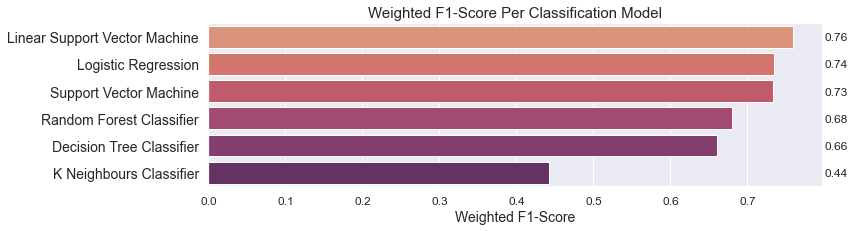

In [ ]:
# Compare Weighted F1-Scores Between Models
fig,axis = plt.subplots(figsize=(11, 3))
rmse_y = ['Linear Support Vector Machine','Logistic Regression','Support Vector Machine','Random Forest Classifier','Decision Tree Classifier','K Neighbours Classifier']
rmse_x = [lsvc_f1, lrm_f1, svc_f1, rfc_f1, dtc_f1 ,knc_f1,]
ax = sns.barplot(y=rmse_y, x=rmse_x,palette='flare')
plt.title('Weighted F1-Score Per Classification Model',fontsize=15)
plt.xlabel('Weighted F1-Score', size=14)
plt.yticks(size=14)
plt.xticks(size=12)
for i in ax.patches:
    ax.text(i.get_x() + i.get_height()/1, i.get_y() + i.get_height()-0.2, round(i.get_width(),2), fontsize=12, ha="left", va='bottom')
    
plt.show()

We can see that LSVM, Logistic Regression and SVM performed the overall best of the models. We will be focusing on the top 3 by hyperparameter tuning, and then proceed to select the best model.

#### Evaluate and compare the time each model takes to train and hyperparameter tune

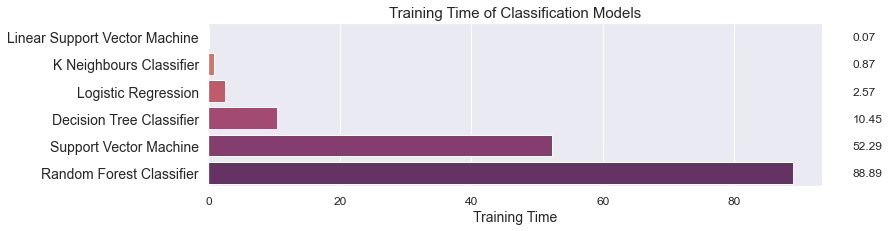

In [ ]:
# Compare Training Times Between Models

fig,axis = plt.subplots(figsize=(11, 3))
rmse_y = ['Linear Support Vector Machine', 'K Neighbours Classifier', 'Logistic Regression','Decision Tree Classifier', 'Support Vector Machine', 'Random Forest Classifier']
rmse_x = [lsvc_time, knc_time, lrm_time, dtc_time, svc_time, rfc_time]
ax = sns.barplot(y=rmse_y, x=rmse_x,palette='flare')
plt.title('Training Time of Classification Models',fontsize=15)
plt.xlabel('Training Time', size=14)
plt.yticks(size=14)
plt.xticks(size=12)
for i in ax.patches:
    ax.text(98, i.get_y() + i.get_height()-0.2, round(i.get_width(),2), fontsize=12, ha="left", va='bottom')
     
plt.show()



We learn that LSVM and Logistic Regression classifiers performed the best in terms of Training time and F1 Performance. (SVM took a long time to train, compared to the other two best models. We will it into consideration when selecting the best model)

<a id="seven"></a>
## 7. Model Performance
<a class="anchor" id="1.1"></a>

### Hyperparameter tuning of best performing Models

We are using GridSearchCV for hyperparameter tuning. K-fold cross-validation is also applied. (as cv = 3)

### Hyperparameter Tuning of Support Vector Classifier

In [ ]:
SVC().get_params() # Run to see the available hyperparameters tuning available for Support Vector Classifier

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters:
{'C': 3, 'kernel': 'rbf'}
Accuracy 0.7528445006321113
Model Runtime: 193.92 seconds
193.92


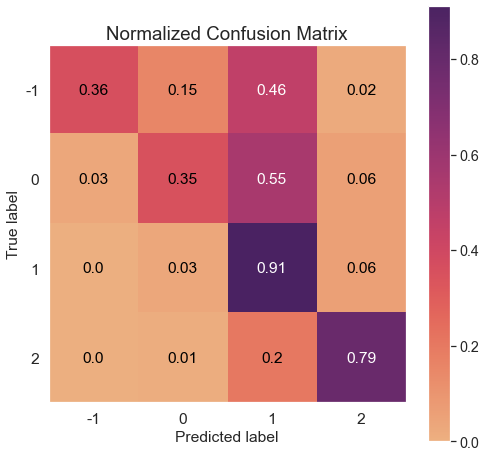

In [ ]:
modeltime = time.time()

param_grid ={'kernel' : ['rbf'],
'C' : [1, 3, 6]}

svc = SVC()
best_svc = GridSearchCV(svc, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
best_svc.fit(X_train ,y_train)
best_svc.best_params_
y_pred = best_svc.predict(X_val)
print("Best parameters:")
print(best_svc.best_params_)

svc_f1 = round(f1_score(y_val, y_pred, average='weighted'),4)
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
svc_time = round(((time.time() - modeltime)),2)
print(svc_time)

# Create Classification Report
report = classification_report(y_val, y_pred, output_dict=True)
results = pd.DataFrame(report).transpose()

# A confusion matrix is used to evaluate the performance of the model

plot_confusion_matrix(y_val, y_pred, normalize=True,figsize=(8,8),cmap='flare')
plt.show()

In [ ]:
# A Classification report is used to measure the quality of predictions from a classification algorithm
results

,precision,recall,f1-score,support
-1,0.810345,0.361538,0.500000,130.000000
0,0.633588,0.353191,0.453552,235.000000
1,0.746615,0.905041,0.818230,853.000000
2,0.805014,0.793956,0.799447,364.000000
accuracy,0.752845,0.752845,0.752845,0.752845
macro avg,0.748890,0.603432,0.642807,1582.000000
weighted avg,0.748499,0.752845,0.733586,1582.000000


### Hyperparameter Tuning of Linear Support Vector Machine

In [ ]:
LinearSVC().get_params() # Run to see the available hyperparameters tuning available for Linear Support Vector Machine

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters:
{'C': 1, 'max_iter': 100, 'random_state': None}
Accuracy 0.7515802781289507
Model Runtime: 22.58 seconds
22.58


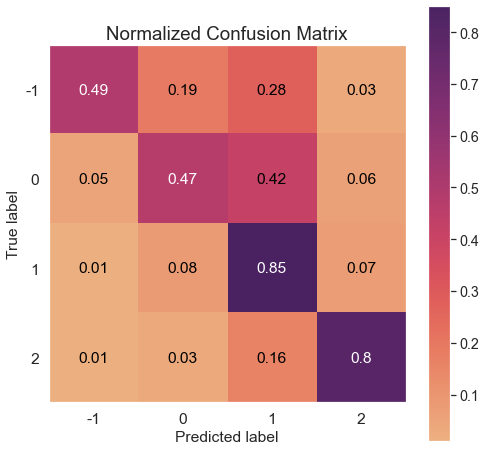

In [ ]:
modeltime = time.time()

param_grid = {'C': [1, 10],
'max_iter': [75, 100],
'random_state' : [None, 42]} 

lsvc = LinearSVC()
best_lsvc = GridSearchCV(lsvc, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
best_lsvc.fit(X_train ,y_train)
best_lsvc.best_params_
y_pred = best_lsvc.predict(X_val)
print("Best parameters:")
print(best_lsvc.best_params_)

lsvc_f1 = round(f1_score(y_val, y_pred, average='weighted'),4)
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
lsvc_time = round(((time.time() - modeltime)),2)
print(lsvc_time)

# Create Classification Report
report = classification_report(y_val, y_pred, output_dict=True)
results = pd.DataFrame(report).transpose()

# A confusion matrix is used to evaluate the performance of the model

plot_confusion_matrix(y_val, y_pred, normalize=True,figsize=(8,8),cmap='flare')
plt.show()

In [ ]:
# A Classification report is used to measure the quality of predictions from a classification algorithm
results

,precision,recall,f1-score,support
-1,0.744186,0.492308,0.592593,130.00000
0,0.523810,0.468085,0.494382,235.00000
1,0.788210,0.846424,0.816280,853.00000
2,0.791892,0.804945,0.798365,364.00000
accuracy,0.751580,0.751580,0.751580,0.75158
macro avg,0.712024,0.652941,0.675405,1582.00000
weighted avg,0.746164,0.751580,0.745960,1582.00000


### Hyperparameter Tuning of Logistic Regression Model

In [ ]:
LogisticRegression().get_params() # Run to see the available hyperparameters tuning available for Logistic Regression

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Best parameters:
{'C': 1, 'max_iter': 100}
Accuracy 0.7572692793931732
Model Runtime: 155.95 seconds
155.95


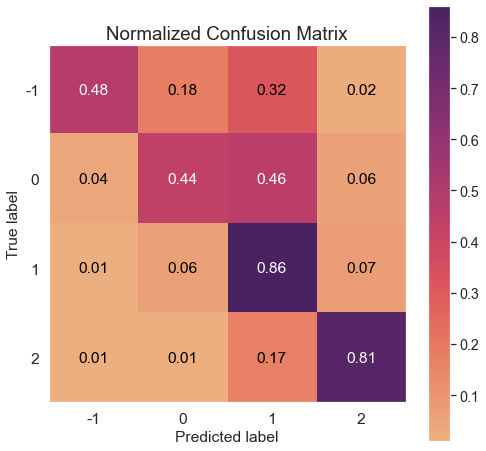

In [ ]:
modeltime = time.time()

param_grid ={'C' : [1, 10],
'max_iter' : [10, 100, 1000]}

lrm = LogisticRegression()
best_log = GridSearchCV(lrm, param_grid = param_grid, cv = 3)
best_log.fit(X_train ,y_train)
best_log.best_params_

y_pred = best_log.predict(X_val)
print("Best parameters:")
print(best_log.best_params_)

lrm_f1 = round(f1_score(y_val, y_pred, average='weighted'),4)
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
lrm_time = round(((time.time() - modeltime)),2)
print(lrm_time)

# Create Classification Report
report = classification_report(y_val, y_pred, output_dict=True)
results = pd.DataFrame(report).transpose()

# A confusion matrix is used to evaluate the performance of the model

plot_confusion_matrix(y_val, y_pred, normalize=True,figsize=(8,8),cmap='flare')
plt.show()

In [ ]:
# A Classification report is used to measure the quality of predictions from a classification algorithm
results

,precision,recall,f1-score,support
-1,0.787500,0.484615,0.600000,130.000000
0,0.556150,0.442553,0.492891,235.000000
1,0.777426,0.864009,0.818434,853.000000
2,0.801090,0.807692,0.804378,364.000000
accuracy,0.757269,0.757269,0.757269,0.757269
macro avg,0.730541,0.649718,0.678926,1582.000000
weighted avg,0.750829,0.757269,0.748892,1582.000000


### Performance 
Evaluate increased performance after Hyperparameter Tuning

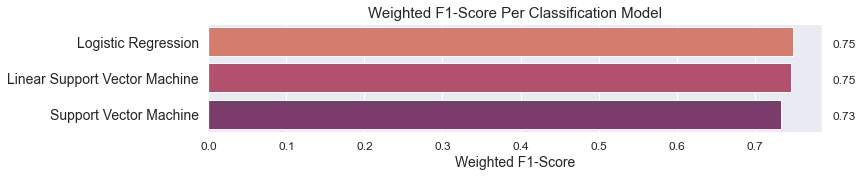

In [ ]:
# Compare Weighted F1-Scores Between Models

fig,axis = plt.subplots(figsize=(11, 2))
rmse_y = ['Logistic Regression','Linear Support Vector Machine','Support Vector Machine']
rmse_x = [lrm_f1,lsvc_f1,svc_f1]
ax = sns.barplot(y=rmse_y, x=rmse_x,palette='flare')
plt.title('Weighted F1-Score Per Classification Model',fontsize=15)
plt.xlabel('Weighted F1-Score', size=14)
plt.yticks(size=14)
plt.xticks(size=12)
for i in ax.patches:
    ax.text(i.get_x() + i.get_height()*1, i.get_y() + i.get_height()-0.2, round(i.get_width(),2), fontsize=12, ha="left", va='bottom')
    
plt.show()

After hyperparameter tuning, Logistic Regression and Linear SVM are the still highest performing models based on F1 Score. 

### Logging Results to Comet
Linear Support Vector Machine is the best overall performing classifier. Comet is used to run experiments on a mid with different hyperparameters, return reports, graphs and other insights which we can use to ultimately choose the best hyperparameters.

In [ ]:
#Uncomment below to log experiment results and end experiment.

"""# Get necessary metrix for comet experiment
f1_svc = f1_score(y_val, y_pred, average='weighted')
precision_svc = precision_score(y_val, y_pred, average='weighted')
recall_svc = recall_score(y_val, y_pred, average='weighted')
accuracy_svc = accuracy_score(y_val, y_pred)

# Create dictionaries for the data we want to log
#params_comet = best_log.best_params_
metrics_svc = {"Accuracy": accuracy_svc, "f1" : f1_svc, "recall" : recall_svc, "precision": precision_svc}

# log our parameters and results
experiment.log_parameters(best_log.best_params_)
experiment.log_metrics(metrics_svc)

# log confusion matrix
experiment.log_confusion_matrix(list(y_val), list(y_pred), normalize=True,figsize=(8,8),cmap='flare')
experiment.end()"""

'# Get necessary metrix for comet experiment\nf1_svc = f1_score(y_val, y_pred, average=\'weighted\')\nprecision_svc = precision_score(y_val, y_pred, average=\'weighted\')\nrecall_svc = recall_score(y_val, y_pred, average=\'weighted\')\naccuracy_svc = accuracy_score(y_val, y_pred)\n\n# Create dictionaries for the data we want to log\n#params_comet = best_log.best_params_\nmetrics_svc = {"Accuracy": accuracy_svc, "f1" : f1_svc, "recall" : recall_svc, "precision": precision_svc}\n\n# log our parameters and results\nexperiment.log_parameters(best_log.best_params_)\nexperiment.log_metrics(metrics_svc)\n\n# log confusion matrix\nexperiment.log_confusion_matrix(list(y_val), list(y_pred), normalize=True,figsize=(8,8),cmap=\'flare\')\nexperiment.end()'

In [ ]:
#experiment.display()

### Make Predictions on Test Data

In [ ]:
X_test = test_df['final_message']
X_test = vect.transform(X_test)

In [ ]:
# predict on test data using logistic Regression - Best performing Model with best hyperparameters (C=1, max_iter=100)
lrm = LogisticRegression(C = 1, max_iter = 100)
lrm.fit(X, y)
y_pred = lrm.predict(X_test)

In [ ]:
test_df['sentiment'] = y_pred

<a id="eight"></a>
## 8. Conclusion
<a class="anchor" id="1.1"></a>
We have chosen the **Logistic Regression Classifier**

- Logistic Regression algorithm performs the best when looking at the model's F1-Score on predicting whether a person believe in climate change or not based on twitter  messages, on unseen data.


- Logistic Regression performed the 3rd best regarding model training time.         
    - Logistic Regression train time is varies under 10 seconds.
    - Although it was not the fastest, the train time is still very acceptable and considered quite fast.
    
  
- Logistic Regression scored 0.76444 when submitted on Kaggle.


- Interestingly, the Logistic Regression model performs worse when Stop Words are removed.


- After extensive hyperparameter tuning, we found {'C': 1, 'max_iter': 100} to result best in sentiment prediction.


- Comet was used with hyperparameter tuning, in comparing numerous experiments made with different parameters, helping us find the best hyperparameters.

<a id="ten"></a>
## 9. Submission
<a class="anchor" id="1.1"></a>
Creating a submission file to be submitted to kaggle with specified columns

In [ ]:
test_df[['tweetid','sentiment']].to_csv('submission.csv', index=False)